## Fixed vs Sliding Windows: Data Suppression

* Combined detector expected to produce c. 40 MHz of hit signals (combined dark noise rate of all PMTs)
* Plan: Zero suppression to avoid recording all this noise data
* Easily implemented rejection criteria:
  * Threshold of hits in time window
  * Length of time window
  * Algorithm (fixed windows vs. sliding window)
* Hard to implement/verify criteria:
  * Fast reconstruction
  * Topological decisions
  * Dynamic threshold changes

# Fixed Window vs. Sliding Window
* Fixed Window:
  * easy to calculate
  * pure Poisson
  * independent events
* Sliding Window:
  * more permissive
  * requires longer time windows
  * window can "bridge" events


# Visual Example
![WindowTypes1](img/window-comp1.png)

This sketch shows a random distribution of hits, split into equal time bins, highlighting which ones are above threshold and which ones aren't. Below is an example of a sliding window sweeping across.

![WindowTypes2](img/window-comp2.png)

This sketch shows the selected hits, the bottom part shows which sliding windows can be drawn to include the hits that are excluded in the fixed window, highlighting the more permissive nature of a sliding window via "bridging"

# Libraries and Functions
The next few cells setup the basic libraries and the functions to generate the hits as well as the implementation of the sliding window

In [1]:
# necessary libraries
%matplotlib inline
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
MHz = 1000000 # so we can just use MHz as unit
ns = 1000000000 # nanoseconds in 1s

In [2]:
def generatePoissonHits(timewindow, noiseRate):
   
   # average time between hits in ns
   avgTime = ns/(noiseRate*MHz)
   generationActive = True
   runningHitTime = 0
   nHits = 0

   # generate hits until we the running event time
   # exceeds the timewindow for the generation
   while generationActive:
      generatedHitTime = rnd.expovariate(1/avgTime)
      runningHitTime += generatedHitTime
      if(runningHitTime < timewindow):
         nHits += 1
      else:
         generationActive = False
   
   return nHits

In [3]:
def generatePoissonList(timespan, noiseRate):

   # average time between hits in ns
   avgTime = ns/(noiseRate*MHz)
   generationActive = True
   runningHitTime = 0
   hitIndex = 0
   hitList = []

   # generate a list of hit until the event time
   # exceeds the requested time span to be sampled
   # NB: this is not the window, that's an extra step
   while generationActive:
      generatedHitTime = rnd.expovariate(1/avgTime)
      runningHitTime += generatedHitTime
      if(runningHitTime < timespan):
         hit = [runningHitTime, False]
         hitList.append(hit)
         hitIndex += 1
      else:
         generationActive = False
   return hitList

In [4]:
def applySlidingWindow(hitList, slidingSize, hitThreshold):

   # get length of the list of hits
   listLength = len(hitList)

   # we use each hit as starting point for a window
   for i in range(listLength-hitThreshold):
      startTime = hitList[i][0]
      hitsInWindow = 1

      # now we check the next n hits and whether
      # they are within the time window slidingSize
      for j in range(hitThreshold):
         deltaTime = hitList[i+j+1][0] - startTime
         if(deltaTime <= slidingSize):
            hitsInWindow += 1
   
      # if the hits within the window exceeds
      # the threshold, we set all of these hits
      # to True (i.e. selected)
      if hitsInWindow > hitThreshold:
         hitList[i][1] = True
         for j in range(hitThreshold):
            deltaTime = hitList[i+j+1][0] - startTime
            if(deltaTime <= slidingSize):
               hitList[i+j+1][1] = True

   # now iterate over list and count
   # all selected hits that are True
   totalHits = 0
   for i in range(listLength):
      if hitList[i][1] == True:
         totalHits +=1

   # return this number
   return totalHits

# Calculation Parameters (make adjustments here)
The next cell contains the basic variables defining the simulation:
* **darkNoiseRate:** This is the combined detector dark noise rate in MHz, default is *40 MHz*
* **windowSize:** The time window used in ns, default is *100 ns*
* **maxThreshold:** This notebook will compute the effect of different thresholds up to this value, default is *20*
* **samples:** How many time windows the script will test (for the sliding window, this is effectively a time equal to the window length times the number of time windows), default is *100,000*, but to lower the uncertainty, crank it up to at least 1M
* **debugOutput:** Whether the notebook will generate the intermediate output... default is *False*

In [5]:
# setup variables
darkNoiseRate = 40 # in MHz, default: 40 MHz
windowSize = 100 # in ns, default: 100 ns
maxThreshold = 10 # default: 10
samples = 100000 # default: 100000
debug = False # default: False

In [6]:
# convertToHz normalises events to 1s (i.e. Hz)
convertToHz = (ns/windowSize)/samples
convertTokHz = convertToHz/1000
convertToMHz = convertToHz/1000000

# avg time between
avgTime = ns/(darkNoiseRate*MHz)
if debug:
    print("avg Time:", avgTime)

# we want to run over several thresholds
yFixed = []
ySliding = []
xThreshold = []

In [7]:
print("Starting calculations...")
for threshold in range(0,maxThreshold+1):

   if debug:
      print("Running threshold", threshold)
   xThreshold.append(threshold)

   # generate a Poisson events independently,
   # i.e. sample many fixed windows
   fixedRate = 0
   for i in range(samples):
      hits = generatePoissonHits(windowSize, darkNoiseRate)
      if hits > threshold:
         fixedRate += hits
   if debug:
      print("Fixed Rate (kHz):", fixedRate*convertTokHz)
   yFixed.append(fixedRate*convertTokHz)

   # generate hit list for sliding window
   allHits = generatePoissonList(samples*windowSize,40)

   # then apply sliding window to that list
   # special case of threshold = 0, as function
   # will fail, so just use everything!
   slidingRate = 0
   if threshold > 0:
      slidingRate = applySlidingWindow(allHits, windowSize, threshold)
   else:
      slidingRate = len(allHits)

   if debug:
      print("Sliding Rate (kHz):", slidingRate*convertTokHz)
   ySliding.append(slidingRate*convertTokHz)

print("Finished calculations...")

Starting calculations...
Finished calculations...


In [8]:
# print out debug table
if debug:
   print("T'hold\tFixed [kHz]\tSliding [kHz]")
   for t in range(len(xThreshold)):
      print("%.0f\t%.2f\t%.2f" % (xThreshold[t], yFixed[t], ySliding[t]))

# Results
The three lists (xThreshold, yFixed, ySliding) hold the respective values of registered hits. These are converted into a table and a (smoothed) plot below for presentations.

In [9]:
# turn into nice table for data frame + printing
resultTable = []
for t in range(len(xThreshold)):
    resultTable.append([xThreshold[t], round(yFixed[t],2), round(ySliding[t],2)])

# load pandas and IPython display
import pandas as pd
from IPython.display import display, HTML

# convert into dataframe
resultData = pd.DataFrame(resultTable, columns=["Threshold", "Fixed Window [kHz]", "Sliding Window [kHz]"])
display(HTML(resultData.to_html(index=False)))

Threshold,Fixed Window [kHz],Sliding Window [kHz]
0,40064.2,39934.1
1,39221.4,40032.2
2,36244.6,39810.5
3,30444.8,38683.5
4,22675.9,35343.5
5,14899.1,29116.5
6,8593.0,21208.0
7,4404.3,13576.2
8,1982.7,7656.2
9,851.5,3803.2


In [10]:
# interpolate for nicer looking plot
spl1 = make_interp_spline(xThreshold, yFixed, k=3)
spl2 = make_interp_spline(xThreshold, ySliding, k=3)
xnew = np.linspace(0,maxThreshold,maxThreshold*10)
ysmoothf = spl1(xnew)
ysmooths = spl2(xnew)

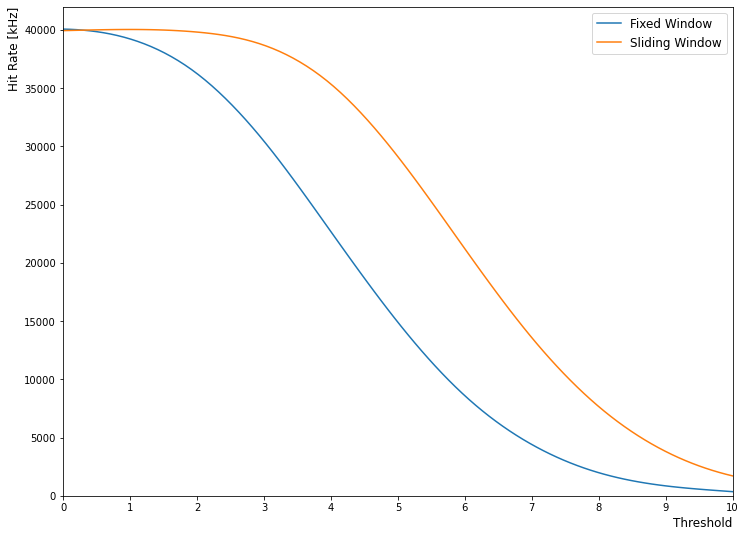

In [11]:
# setup plotting
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xticks(np.arange(len(xThreshold)))
ax.set_ylim(ymin=0, ymax=42000)
ax.set_xlim(xmin=0)
ax.yaxis.label.set_size(12)
ax.xaxis.label.set_size(12)

plt.xlabel('x_description', horizontalalignment='right', x=1.0)
plt.ylabel('y_description', horizontalalignment='right', y=1.0)

plt.xlabel("Threshold")
plt.ylabel("Hit Rate [kHz]")

# plot the whole thing and legends
plt.plot(xnew,ysmoothf, label="Fixed Window")
plt.plot(xnew,ysmooths, label="Sliding Window")
plt.legend(loc=1, prop={'size': 12})

# show plot
plt.show()